In [0]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import torchvision.utils as vutils
import time

import matplotlib.pyplot  as plt
%matplotlib inline

# Part A
## Model Design
- Use Gaussian {encoder, prior, decoder } with 3 different latent space sizes of
{1,2,16 }. Use the typical linear layers used in pytorch models https://github.com/pytorch/examples/tree/master/vae. Use Learing rate of 0.001. Dont go
more than 30 Epochs

## Deliverables
- Visualise the latent space for latent dimension of 1 and 2 for the posterior.
- Generate 500 samples from posterior and 500 from the prior for latent dimension
of 1 and visualise them together in a diagram. Do they match each other?
- Generate 128 samples from the prior and decode them. How different are samples
from models with different latent size? How different the decoded samples are
when you traverse through prior space?

In [0]:
batch_size = 100
learning_rate = 0.001
latent_spaces = [1,2,16]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
trainset = datasets.MNIST('train_data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('test_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
plot_data = trainset.data[:500]

In [0]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(train_loader)
images, _ = dataiter.next()
images.shape

torch.Size([100, 1, 28, 28])

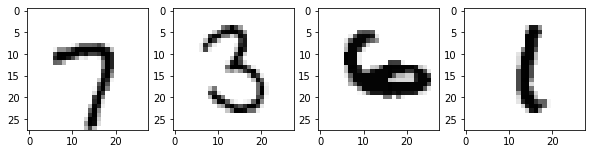

In [6]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  # image = image.reshape(1, 28, 28)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(image.numpy().squeeze(), cmap='gray_r')
  

for i in range(0, 4):
  show_image(i, images[i])
plt.show()

In [0]:
# https://github.com/pytorch/examples/blob/master/vae/main.py
class VAE(nn.Module):
  def __init__(self, latent_size=1):
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(784, 400)
    self.fc21 = nn.Linear(400, latent_size)
    self.fc22 = nn.Linear(400, latent_size)
    self.fc31 = nn.Linear(latent_size, 400)
    self.fc32 = nn.Linear(latent_size, 400)    
    self.fc4 = nn.Linear(400, 784)


  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  @staticmethod
  def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h31 = F.relu(self.fc31(z))
    h32 = F.relu(self.fc32(z))
    return self.fc4(h31), self.fc4(h32)

  def sample(self, z):
    de_mu, de_log_var = self.decode(z)
    full_generation_path = self.reparameterize(de_mu, de_log_var)
    without_decoder_noise = de_mu
    return full_generation_path, without_decoder_noise

  def forward(self, x):
    en_mu, en_log_var = self.encode(x.view(-1, 784))
    z = self.reparameterize(en_mu, en_log_var)
    de_mu, de_log_var = self.decode(z)
    deconstruction = self.reparameterize(de_mu, de_log_var)
    return en_mu, en_log_var, z, de_mu, de_log_var, deconstruction
  
  @staticmethod
  def loss(x, en_mu, en_log_var, de_mu, de_log_var):
    # print("mu:", en_mu, "\ņ log_var", en_log_var, "\n de_mu", de_mu, "\n de_loga_var", de_log_var)
    decoder_std = torch.exp(0.5 * de_log_var)
    reconstruction_loss = torch.mean(- (Normal(de_mu, decoder_std).log_prob(x.view(-1, 784))) ) / np.log(2)

    kl_loss = torch.mean(-0.5 * torch.sum(1 + en_log_var - en_mu.pow(2) - en_log_var.exp(), dim=-1))
    # print("kl:", torch.mean(kl_loss), "recon_loss:", reconstruction_loss)
    ELBO = reconstruction_loss + kl_loss
    return ELBO, kl_loss, reconstruction_loss

In [0]:
def train_vae(vae, epochs=26):
  optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate)

  EPOCH = epochs
  train_loss = []
  train_kld = []
  train_nll = []

  val_loss = []
  val_kld = []
  val_nll = []

  for epoch in range(EPOCH):
    vae.train()
    start_time = time.time()
    for i, x in enumerate(train_loader, 0):
      x, _ = x
      x = x.to(device).float()
    
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      mu, log_var, _, de_mu, de_log_var, _ = vae(x)

      loss, kld, nll = vae.loss(x, mu, log_var, de_mu, de_log_var)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      train_kld.append(kld.item())
      train_nll.append(nll.item())
    # print statistics
    with torch.set_grad_enabled(False):
      for val_batch in test_loader:
        x_val, _ = val_batch
        x_val = x_val.to(device).float()
        mu, log_var, _, de_mu, de_log_var, _ =  vae(x_val)
        v_loss, v_kld, v_nll = vae.loss(x_val, mu, log_var, de_mu, de_log_var)

        val_loss.append(v_loss.item())
        val_kld.append(v_kld.item())
        val_nll.append(v_nll.item())
      sec = (time.time() - start_time)
    if (epoch % 5 == 0):
      print("--- epoch:", epoch, "sec:", sec, "---")
      print("loss:", loss.item(), "val loss:", v_loss.item(), 
            "KLD:", kld.item(), "val KLD:", v_kld.item(), "\n")
  return train_loss, train_kld, train_nll, val_loss, val_kld, val_nll

In [0]:
def plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll): 
  f, axarr = plt.subplots(1,3, figsize=(15,5))

  ax = axarr[0]
  ax.set_title('ELBO')
  ax.plot(train_loss, label = "ELBO_train_loss")
  ax.plot(np.arange(0, len(train_loss),(len(train_loss)/len(val_loss))), val_loss, label = "ELBO_val_loss")

  ax = axarr[1]
  ax.set_title('KL')
  ax.plot(train_kld, label = "kld_train_loss")
  ax.plot(np.arange(0, len(train_kld),(len(train_kld)/len(val_kld))), val_kld, label = "KL_val_loss")

  ax = axarr[2]
  ax.set_title('NLL')
  ax.plot(train_nll, label = "NLL_train_loss")
  ax.plot(np.arange(0, len(train_nll),(len(train_nll)/len(val_nll))), val_nll, label = "NLL_val_loss")
  plt.show()

In [0]:
from sklearn.manifold import TSNE
def plot_samples(vae, plot_data, latent_space):
  fig = plt.subplots(figsize=(4,4))
  vae.eval()
  z = torch.randn(500, latent_space).to(device)
  full_generation_path, without_decoder_noise = vae.sample(z)
  full_generation_path = full_generation_path.cpu().data.numpy().reshape(-1,28,28) 
  without_decoder_noise = without_decoder_noise.cpu().data.numpy().reshape(-1,28,28)
  mu, log_var, z, x_mu, x_log_var, deconstruction = vae(plot_data.to(device).float())

  latent_space_z = z.cpu().data.numpy()

  if latent_space == 1:
    plt.title('latent space')
    plt.scatter(latent_space_z, np.zeros(latent_space_z.shape))
  elif latent_space == 2:
    plt.title('latent space')
    plt.scatter(latent_space_z[:,0], latent_space_z[:,1])
  else:
    z_embedded = TSNE(n_components=2).fit_transform(latent_space_z)
    plt.title('latent space')
    plt.scatter(z_embedded[:,0], z_embedded[:,1])
  plt.show()
 
  f, axarr = plt.subplots(2, 2, figsize=(8,8))
  decon_image = deconstruction.cpu().data.numpy().reshape(-1,28,28)[:4,:,:]
  for i in range(2):
    for j in range(2):
      ax = axarr[i][j]
      ax.set_title(str(i+j) + ' Reconstruced samples')
      ax.imshow(decon_image[i+j], cmap='gray_r')
      ax.axis('equal')
  plt.show()
  
  f, axarr = plt.subplots(2, 2, figsize=(8,8))
  for i in range(2):
    for j in range(2):
      ax = axarr[i][j]
      ax.set_title(str(i+j) + ' Reconstruced samples')
      ax.imshow(full_generation_path[i+j], cmap='gray_r')
      ax.axis('equal')
  plt.show()

  f, axarr = plt.subplots(2, 2, figsize=(8,8))
  for i in range(2):
    for j in range(2):
      ax = axarr[i][j]
      ax.set_title(str(i+j) + ' Reconstruced samples')
      ax.imshow(without_decoder_noise[i+j], cmap='gray_r')
      ax.axis('equal')
  plt.show()

--- epoch: 0 sec: 7.23986029624939 ---
loss: -1.4359393119812012 val loss: -1.3769490718841553 KLD: 0.005968947429209948 val KLD: 0.00664976891130209 

--- epoch: 5 sec: 7.195082187652588 ---
loss: -1.252284288406372 val loss: -1.1361641883850098 KLD: 0.023352131247520447 val KLD: 0.01424980629235506 

--- epoch: 10 sec: 7.0756378173828125 ---
loss: -1.706272840499878 val loss: -1.5980591773986816 KLD: 0.019787555560469627 val KLD: 0.01881641335785389 

--- epoch: 15 sec: 7.13541579246521 ---
loss: -1.4609555006027222 val loss: -1.5605018138885498 KLD: 0.039443619549274445 val KLD: 0.041521523147821426 

--- epoch: 20 sec: 7.032358646392822 ---
loss: -1.6167367696762085 val loss: -1.7224085330963135 KLD: 0.021914705634117126 val KLD: 0.012769358232617378 

--- epoch: 25 sec: 7.568562746047974 ---
loss: -1.5899860858917236 val loss: -1.646877646446228 KLD: 0.0273573100566864 val KLD: 0.034352224320173264 



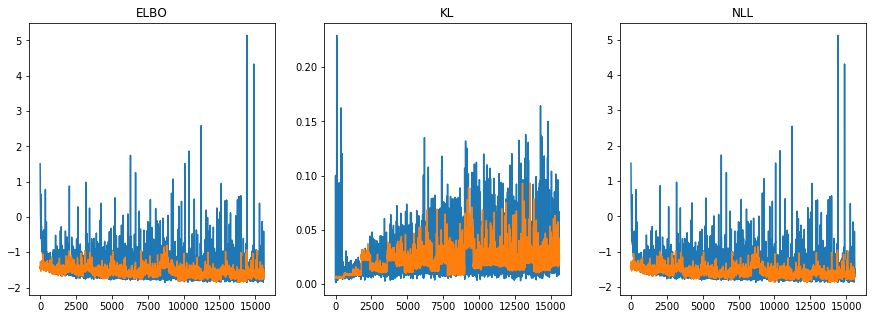

In [11]:
latent_space = latent_spaces[0]
vae = VAE(latent_space).to(device)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae)
plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll)

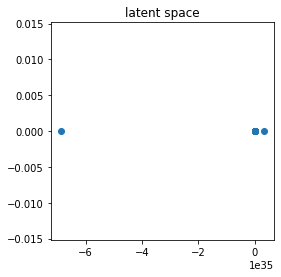

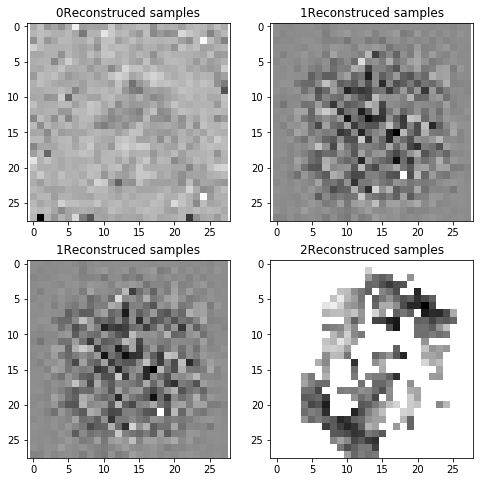

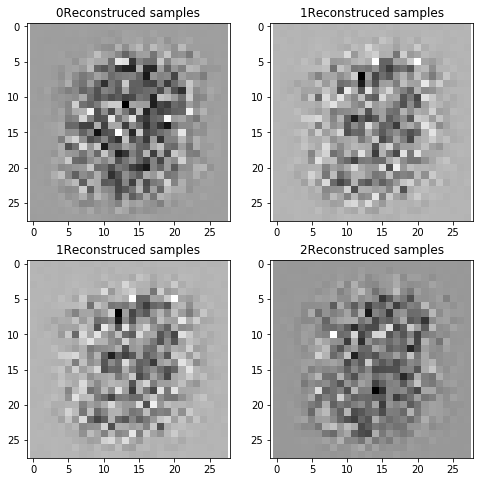

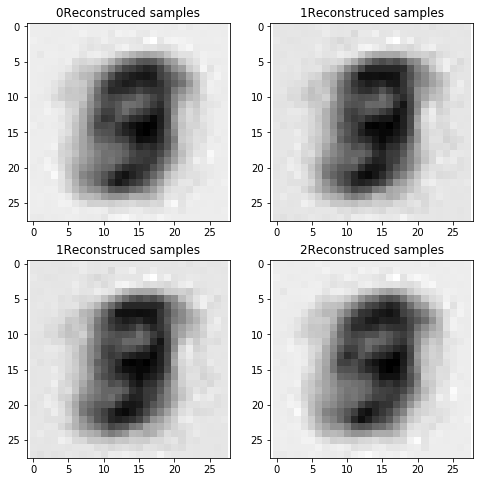

In [12]:
plot_samples(vae, plot_data, latent_space)

--- epoch: 0 sec: 7.291258811950684 ---
loss: -1.2874711751937866 val loss: -1.3275012969970703 KLD: 0.007550361100584269 val KLD: 0.008104786276817322 

--- epoch: 5 sec: 7.143696069717407 ---
loss: -1.5025348663330078 val loss: -1.445194959640503 KLD: 0.013685297220945358 val KLD: 0.010824484750628471 

--- epoch: 10 sec: 7.129824876785278 ---
loss: -1.4177607297897339 val loss: -1.5140037536621094 KLD: 0.023297695443034172 val KLD: 0.01631707325577736 

--- epoch: 15 sec: 7.405919551849365 ---
loss: -1.6188592910766602 val loss: -1.5921356678009033 KLD: 0.04244527593255043 val KLD: 0.05040048807859421 

--- epoch: 20 sec: 7.136981010437012 ---
loss: -1.7172906398773193 val loss: -1.8029786348342896 KLD: 0.09522639214992523 val KLD: 0.07732219249010086 

--- epoch: 25 sec: 7.226170301437378 ---
loss: -1.7693226337432861 val loss: -1.8088080883026123 KLD: 0.07915371656417847 val KLD: 0.09844782948493958 



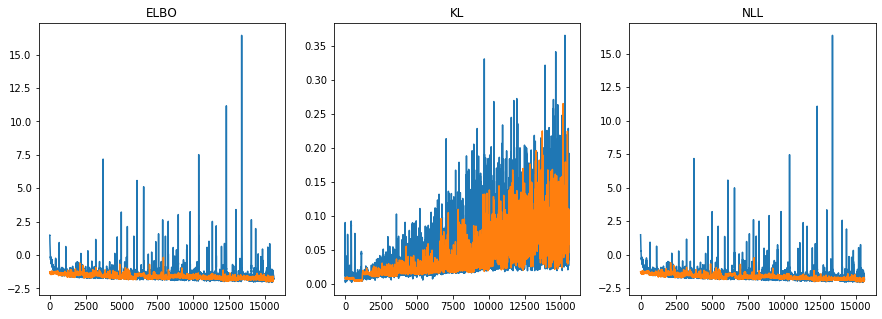

In [13]:
latent_space = latent_spaces[1]
vae = VAE(latent_space).to(device)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae)
plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll)

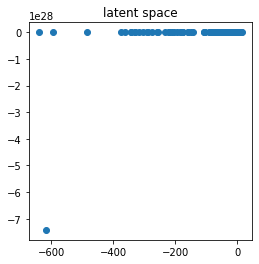

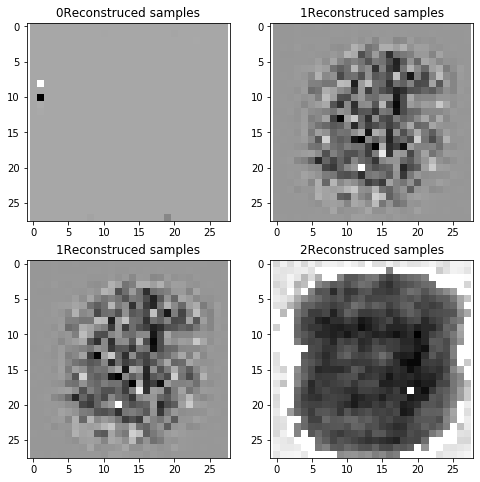

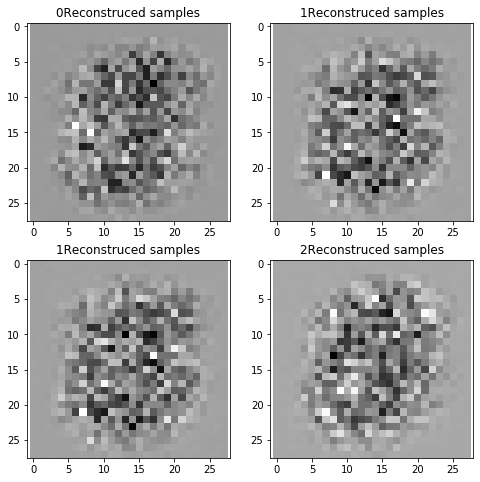

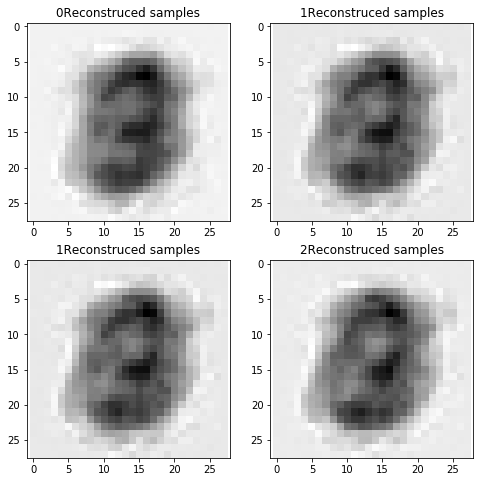

In [14]:
plot_samples(vae, plot_data, latent_space)

--- epoch: 0 sec: 7.0233001708984375 ---
loss: -0.7651523351669312 val loss: -0.7199497222900391 KLD: 0.004441726487129927 val KLD: 0.005603176075965166 

--- epoch: 5 sec: 7.042941093444824 ---
loss: -1.8546618223190308 val loss: -1.7541899681091309 KLD: 0.026161568239331245 val KLD: 0.06304965168237686 

--- epoch: 10 sec: 7.315068244934082 ---
loss: -2.2395105361938477 val loss: -1.0710954666137695 KLD: 0.03301115706562996 val KLD: 0.12645885348320007 

--- epoch: 15 sec: 7.351119518280029 ---
loss: -2.3572421073913574 val loss: -2.3122217655181885 KLD: 0.0853840708732605 val KLD: 0.11346910148859024 

--- epoch: 20 sec: 7.416929006576538 ---
loss: -2.3953232765197754 val loss: -2.515418767929077 KLD: 0.07863640785217285 val KLD: 0.11265815794467926 

--- epoch: 25 sec: 7.011630535125732 ---
loss: -2.3465371131896973 val loss: -2.235346794128418 KLD: 0.08994881063699722 val KLD: 0.28372347354888916 



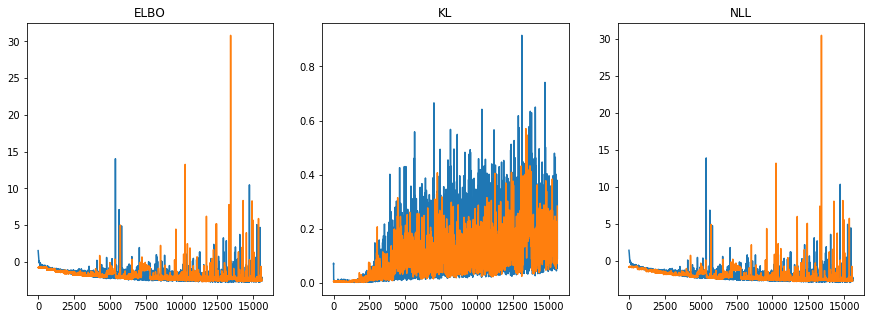

In [15]:
latent_space = latent_spaces[2]
vae = VAE(latent_space).to(device)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae)
plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll)

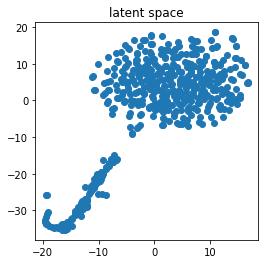

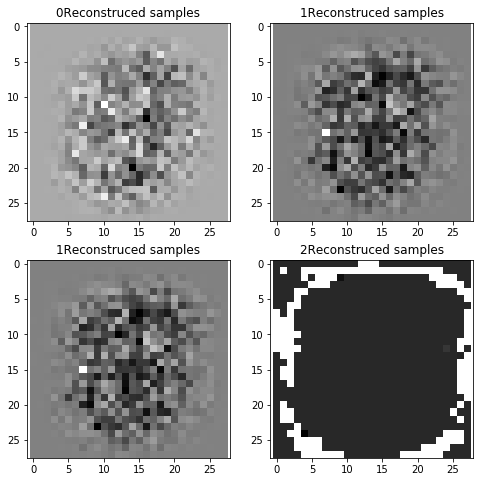

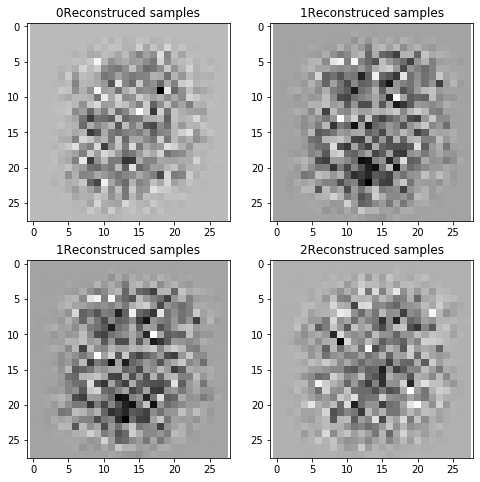

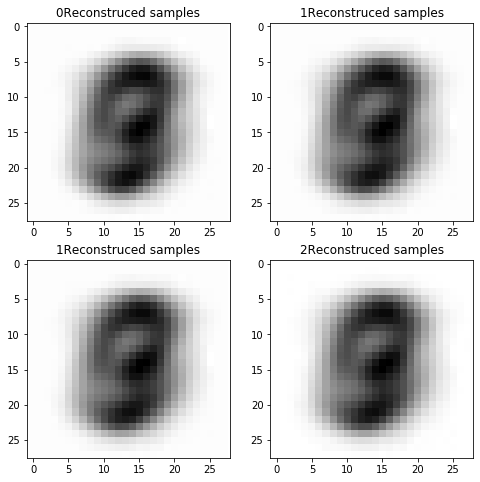

In [16]:
plot_samples(vae, plot_data, latent_space)